# AC Project

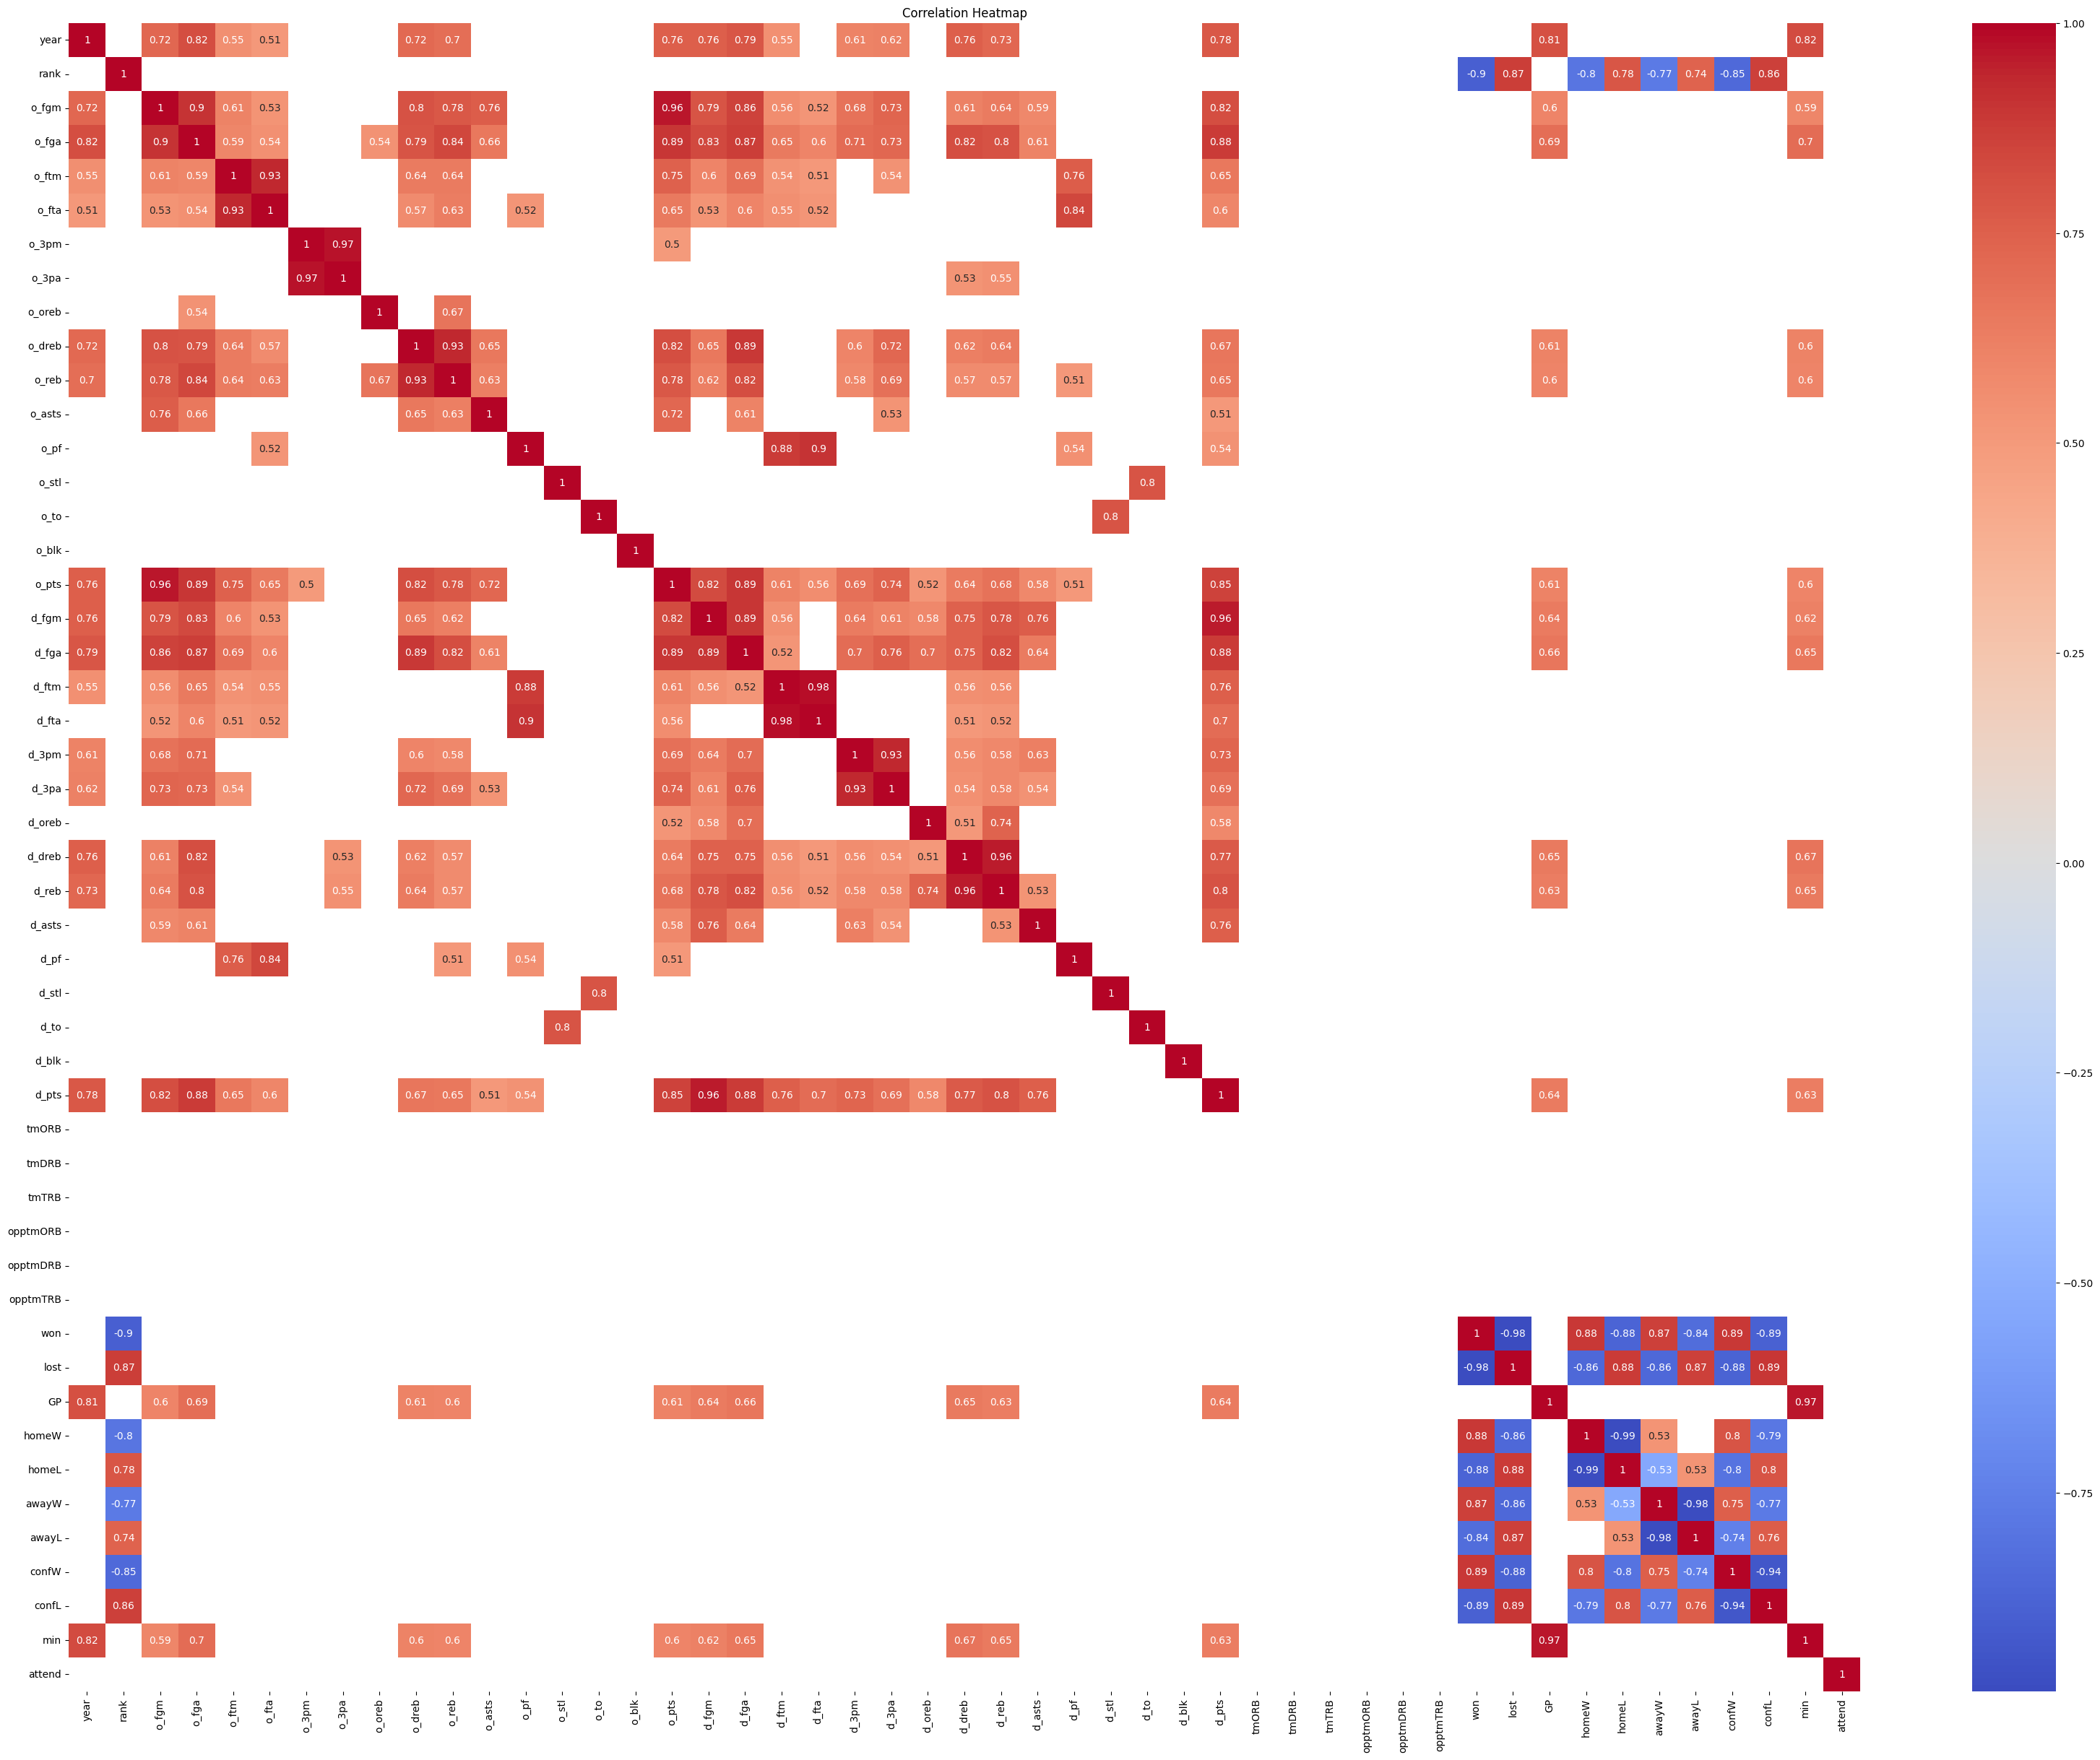

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

teams_data = pd.read_csv("Dataset/teams.csv")
teams_correlation_matrix = teams_data.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = abs(teams_correlation_matrix) < 0.5

# Create a heatmap
plt.figure(figsize=(40, 30))
sns.heatmap(teams_correlation_matrix, annot=True, cmap='coolwarm', mask=mask)

plt.title('Correlation Heatmap')
plt.show()

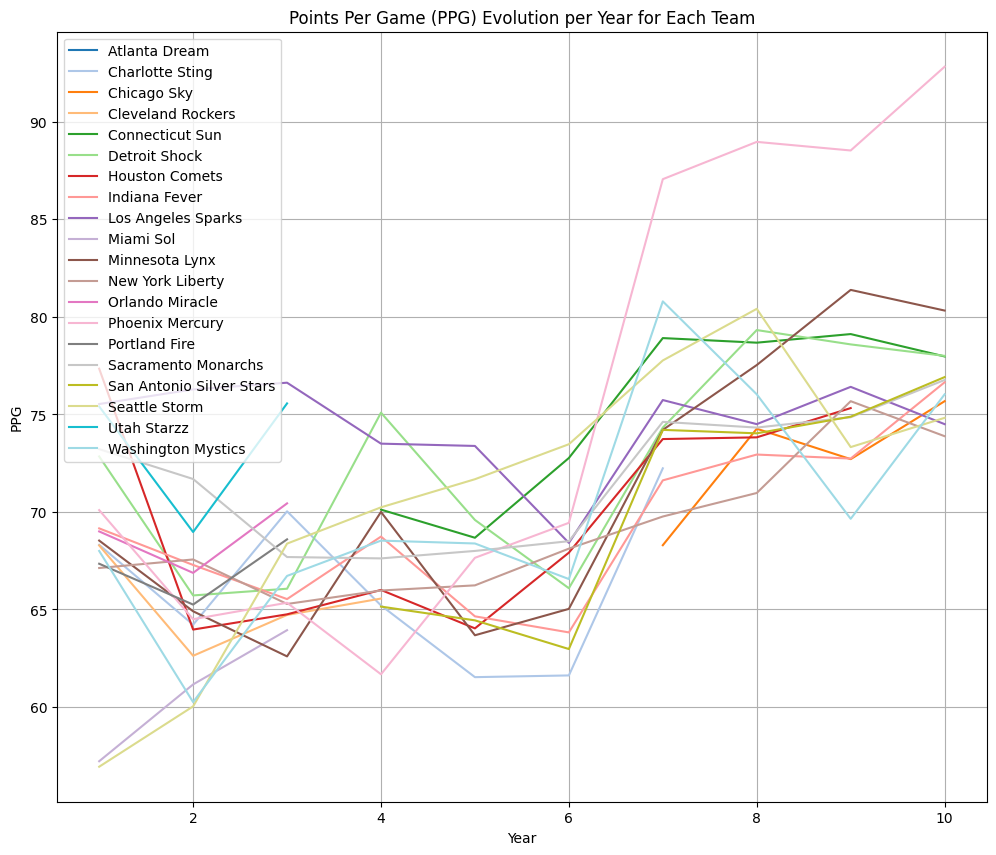

In [2]:
# Add points per game (PPG) column
teams_data['PPG'] = teams_data['o_pts'] / teams_data['GP']
teams_data['opp_PPG'] = teams_data['d_pts'] / teams_data['GP']

ppg_per_team = teams_data.groupby(['name', 'year'])['PPG'].mean().reset_index()

plt.figure(figsize=(12, 10))

colors = plt.cm.tab20([i/len(ppg_per_team['name'].unique()) for i in range(len(ppg_per_team['name'].unique()))])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

for team in ppg_per_team['name'].unique():
    team_data = ppg_per_team[ppg_per_team['name'] == team]
    plt.plot(team_data['year'], team_data['PPG'], label=team)

plt.title('Points Per Game (PPG) Evolution per Year for Each Team')
plt.xlabel('Year')
plt.ylabel('PPG')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [3]:
# Read players_data
players_teams_data = pd.read_csv("Dataset/players_teams.csv")
players_info_data = pd.read_csv("Dataset/players.csv")

# Merge players_teams_data and players_info_data
players_data = pd.merge(players_teams_data, players_info_data, left_on='playerID', right_on='bioID', how='left')

# Drop rows that are not needed
players_data = players_data[players_data.pos.notnull()]
players_data.drop(players_data[players_data['weight'] < 60].index, inplace = True)
players_data.drop(players_data[players_data['height'] < 50 ].index, inplace = True)
players_data.drop(columns=["firstseason","lastseason","deathDate"],inplace=True)
players_data.reset_index()
players_data.describe()

players_data.head()

,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostthreeAttempted,PostthreeMade,PostDQ,bioID,pos,height,weight,college,collegeOther,birthDate
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,0,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,0,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
2,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,7,3,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
3,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,8,2,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
4,abrossv01w,6,0,MIN,31,31,777,304,29,78,...,0,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09


In [4]:
# Read awards data
awards_players_data = pd.read_csv("Dataset/awards_players.csv")

# Add awards column to players_data
players_data['awards'] = 0

for idx, player in players_data.iterrows():
    awards_until_target_season = awards_players_data[(awards_players_data['playerID'] == player['playerID']) & (awards_players_data['year'] < player['year'])]
    if(not awards_until_target_season.empty):
        players_data.loc[[idx], 'awards'] =  len(awards_until_target_season)

players_data.head()

,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostthreeMade,PostDQ,bioID,pos,height,weight,college,collegeOther,birthDate,awards
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0
2,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,3,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0
3,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,2,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0
4,abrossv01w,6,0,MIN,31,31,777,304,29,78,...,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0


In [5]:
# Read coaches data
coaches_data = pd.read_csv("Dataset/coaches.csv")
awards_coaches_data = pd.read_csv("Dataset/awards_coaches.csv")

# Add awards column to coaches_data
coaches_data['awards'] = 0

for idx, coach in coaches_data.iterrows():
    awards_until_target_season = awards_coaches_data[(awards_coaches_data['coachID'] == coach['coachID']) & (awards_coaches_data['year'] < coach['year'])]
    if(not awards_until_target_season.empty):
        coaches_data.loc[[idx], 'awards'] =  len(awards_until_target_season)

In [6]:
from datetime import datetime, date

# Convert birthDate to age
def age(born, year): 
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return (today.year-(25-year)) - born.year - ((today.month, today.day) < (born.month, born.day)) 

factors = {}
vops = {}
drbps = {}
lgFt = {}
lfPF = {}
lgFTA = {}
lgPPG = {}

for year in range(0, 11):
    teams_current_year = teams_data[teams_data['year'] == year]
    pts = teams_current_year['o_pts'].sum()
    fgm = teams_current_year['o_fgm'].sum()
    ftm = teams_current_year['o_ftm'].sum()
    fga = teams_current_year['o_fga'].sum()
    fta = teams_current_year['o_fta'].sum()
    ast = teams_current_year['o_asts'].sum()
    trb = teams_current_year['o_reb'].sum()
    orb = teams_current_year['o_oreb'].sum()
    to = teams_current_year['o_to'].sum()
    pf = teams_current_year['o_pf'].sum()
    ppg = teams_current_year['o_pts'].sum() / (teams_current_year['GP'].sum()/2)

    factors[year] = 2/3 - ((0.5 * (ast / fgm)) / (2 * (fgm / ftm)))
    vops[year] = pts / (fga - orb + to + 0.44 * fta)
    drbps[year] = (trb - orb) / trb
    lgFt[year] = ftm
    lfPF[year] = pf
    lgFTA[year] = fta
    lgPPG[year] = ppg

# Add variables to teams data
for idx, team in teams_data.iterrows():
        # Add average player height column to teams_data
        team_players_until_target_season = players_data[(players_data["year"] == team["year"] )&( players_data["tmID"] == team["tmID"])]
        team_players_avg_height = team_players_until_target_season["height"].mean()
        teams_data.loc[[idx], 'avg_height'] = team_players_avg_height

        # Add average player weight column to teams_data
        team_players_avg_weight = team_players_until_target_season["weight"].mean()
        teams_data.loc[[idx], 'avg_weight'] = team_players_avg_weight

        # Add average player age column to teams_data
        players_ages = team_players_until_target_season["birthDate"].apply(age, args=(team["year"],))
        team_players_avg_age = players_ages.mean()
        teams_data.loc[[idx], 'avg_age'] = team_players_avg_age

        # Add awards column to teams_data
        players = players_data[(players_data["year"] == team["year"] )&( players_data["tmID"] == team["tmID"])]
        team_awards_num = players["awards"].sum()
        teams_data.loc[[idx], 'player_awards'] = team_awards_num
        
        # Add coach awards column to teams_data
        coaches = coaches_data[(coaches_data["year"] == team["year"] )&( coaches_data["tmID"] == team["tmID"])]
        team_coaches_awards_num = coaches["awards"].sum()
        teams_data.loc[[idx], 'coach_awards'] = team_coaches_awards_num

        # Add coach changes during season column to teams_data
        teams_data.loc[[idx], 'coach_changes'] = len(coaches)-1

        # Add number of playoff qualified in last two seasons; 1 if qualified only two years ago, 2 if only last season and 3 if both
        playoff_last_two = 0
        last_season = teams_data[(teams_data["year"] == team["year"]-1)&( teams_data["tmID"] == team["tmID"])]
        older_season = teams_data[(teams_data["year"] == team["year"]-2)&( teams_data["tmID"] == team["tmID"])]
        if(not last_season.empty):
            if(last_season.iloc[0]["playoff"]=='Y'):
                playoff_last_two+=2
        if(not older_season.empty):
            if(older_season.iloc[0]["playoff"]=='Y'):
                playoff_last_two+=1
        teams_data.loc[[idx], 'last_two_playoff'] = playoff_last_two

        # Add uper to players
        year = team["year"]
        for idx2, player in players.iterrows():
            min = player["minutes"] if player["minutes"] > 48 else 0
            treeP = player["threeMade"]
            ast = player["assists"]
            factor = factors[year]
            tmAst = team["o_asts"]
            tmFG = team["o_fgm"]
            fg = player["fgMade"]
            ft = player["ftMade"]
            vop = vops[year]
            to = player["turnovers"]
            drbp = drbps[year]
            fga = player["fgAttempted"]
            fta = player["ftAttempted"]
            trb = player["rebounds"]
            orb = player["oRebounds"]
            stl = player["steals"]
            blk = player["blocks"]
            pf = player["PF"]
            lft = lgFt[year]
            lpf = lfPF[year]
            lfta = lgFTA[year]
            lgppg = lgPPG[year]
            tmPpg = team["PPG"]
            tmOppg = team["opp_PPG"]

            # Add PER column to players_data
            try: 
                uper = (1 / min) * (treeP + (2/3) * ast + (2 - factor * (tmAst / tmFG)) * fg + (ft * 0.5 * (2 - (1/3)*(tmAst/tmFG))) - vop * to - vop * drbp * (fga - fg) - vop * 0.44 * (0.44 + (0.56 * drbp)) * (fta - ft) + vop * (1 - drbp) * (trb - orb) + vop * drbp * orb + vop * stl + vop * drbp * blk - pf * ((lft / lpf) - 0.44 * (lfta / lpf) * vop))
                players_data.loc[[idx2], 'uPER'] = uper
            except:
                players_data.loc[[idx2], 'uPER'] = 0


# Add PER column to players and PER average to teams
for idx, team in teams_data.iterrows():
    year = team["year"]
    lguper = players_data[(players_data["year"] == year )]["uPER"].mean()
    players = players_data[(players_data["year"] == year )&( players_data["tmID"] == team["tmID"])]
    for idx2, player in players.iterrows():
        tmppg = team["PPG"]
        tmoppg = team["opp_PPG"]
        lgppg = lgPPG[year]
        uper = player["uPER"]
        per = uper * (2*lgppg / (tmppg + tmoppg)) * (15 / lguper)
        players_data.loc[[idx2], 'PER'] = per

    teams_data.loc[[idx], 'avg_per'] = players_data[(players_data["year"] == year )&( players_data["tmID"] == team["tmID"])]["PER"].mean()


columns_to_replace = ["o_fgm","o_fga","o_ftm","o_fta","o_3pm","o_3pa","o_oreb","o_dreb","o_reb","o_asts",
                      "o_pf","o_stl","o_to","o_blk","o_pts","d_fgm","d_fga","d_ftm","d_fta","d_3pm",
                      "d_3pa","d_oreb","d_dreb","d_reb","d_asts","d_pf","d_stl","d_to","d_blk","d_pts",
                      "tmORB","tmDRB","tmTRB","opptmORB","opptmDRB","opptmTRB","won","lost","GP",
                      "homeW","homeL","awayW","awayL","confW","confL","min","attend","PPG","coach_changes", "avg_per"]

teams_data_2=teams_data.copy()
for idx, team in teams_data_2.iterrows():
        last_season = teams_data[(teams_data["year"] == team["year"]-1)&( teams_data["tmID"] == team["tmID"])]
        older_season = teams_data[(teams_data["year"] == team["year"]-2)&( teams_data["tmID"] == team["tmID"])]
        if(not last_season.empty):
            if(not older_season.empty):
                for column in columns_to_replace:
                    teams_data_2.loc[[idx], column] = last_season.iloc[0][column]/2+older_season.iloc[0][column]/2      
            else:     
                for column in columns_to_replace:   
                    teams_data_2.loc[[idx], column] = last_season.iloc[0][column] 

teams_data = teams_data_2
teams_data.head()

C:\Users\henri\AppData\Local\Temp\ipykernel_14072\1699850397.py:29: RuntimeWarning: invalid value encountered in double_scalars
  ppg = teams_current_year['o_pts'].sum() / (teams_current_year['GP'].sum()/2)
C:\Users\henri\AppData\Local\Temp\ipykernel_14072\1699850397.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
  factors[year] = 2/3 - ((0.5 * (ast / fgm)) / (2 * (fgm / ftm)))
C:\Users\henri\AppData\Local\Temp\ipykernel_14072\1699850397.py:32: RuntimeWarning: invalid value encountered in double_scalars
  vops[year] = pts / (fga - orb + to + 0.44 * fta)
C:\Users\henri\AppData\Local\Temp\ipykernel_14072\1699850397.py:33: RuntimeWarning: invalid value encountered in longlong_scalars
  drbps[year] = (trb - orb) / trb


,year,tmID,confID,rank,playoff,firstRound,semis,finals,name,o_fgm,...,PPG,opp_PPG,avg_height,avg_weight,avg_age,player_awards,coach_awards,coach_changes,last_two_playoff,avg_per
0,1,CHA,EA,8,N,NaN,NaN,NaN,Charlotte Sting,812.0,...,68.312500,75.906250,71.692308,168.846154,25.384615,0.0,0.0,0.0,0.0,29.582908
1,2,CHA,EA,4,Y,W,W,L,Charlotte Sting,812.0,...,68.312500,62.781250,71.500000,164.416667,25.583333,0.0,0.0,0.0,0.0,29.582908
2,3,CHA,EA,2,Y,L,NaN,NaN,Charlotte Sting,779.0,...,66.265625,66.656250,71.307692,164.923077,26.615385,0.0,0.0,0.0,2.0,30.405816
3,4,CHA,EA,2,Y,L,NaN,NaN,Charlotte Sting,758.0,...,67.125000,64.558824,71.181818,164.454545,26.636364,0.0,0.0,0.0,3.0,30.606482
4,5,CHA,EA,5,N,NaN,NaN,NaN,Charlotte Sting,778.5,...,67.618566,63.764706,72.000000,167.571429,25.785714,0.0,0.0,0.0,3.0,33.706723


### Data Split

In [7]:
teams_data.drop(columns=['rank', 'firstRound', 'semis', 'finals'],inplace=True)
teams_data = teams_data[teams_data.year > 2]

char_map = {'N': 0, 'Y': 1, 'L': 0, 'W': 1}
teams_data['playoff'] = teams_data['playoff'].map(char_map)
teams_data['playoff'] = teams_data['playoff'].fillna(-1)

tmIds = teams_data['tmID'].unique()
for i in range (len(tmIds)):
    teams_data['tmID'] = teams_data['tmID'].replace(tmIds[i],i)

confids = teams_data['confID'].unique()
for i in range (len(confids)):
    teams_data['confID'] = teams_data['confID'].replace(confids[i],i)

arenas = teams_data['arena'].unique()
for i in range (len(arenas)):
    teams_data['arena'] = teams_data['arena'].replace(arenas[i],i)

tmNames = teams_data['name'].unique()
for i in range (len(tmNames)):
    teams_data['name'] = teams_data['name'].replace(tmNames[i],i)

teams_data_conf_1 = teams_data[(teams_data['confID'] == 0) & (teams_data['year'] < 10)]
teams_test_conf_1 = teams_data[(teams_data['confID'] == 0) & (teams_data['year'] == 10)]

teams_data_conf_2 = teams_data[(teams_data['confID'] == 1) & (teams_data['year'] < 10)]
teams_test_conf_2 = teams_data[(teams_data['confID'] == 1) & (teams_data['year'] == 10)]

teams_test = teams_data[teams_data['year'] == 10]
teams_data = teams_data[teams_data['year'] < 10]

X_train_conf_1, X_test_conf_1, y_train_conf_1, y_test_conf_1 = teams_data_conf_1.drop(columns=['playoff']), teams_test_conf_1.drop(columns=['playoff']), teams_data_conf_1['playoff'], teams_test_conf_1['playoff']
X_train_conf_2, X_test_conf_2, y_train_conf_2, y_test_conf_2 = teams_data_conf_2.drop(columns=['playoff']), teams_test_conf_2.drop(columns=['playoff']), teams_data_conf_2['playoff'], teams_test_conf_2['playoff']
X_train, X_test, y_train, y_test = teams_data.drop(columns=['playoff']), teams_test.drop(columns=['playoff']), teams_data['playoff'], teams_test['playoff']

C:\Users\henri\AppData\Local\Temp\ipykernel_14072\358411015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams_data['playoff'] = teams_data['playoff'].map(char_map)
C:\Users\henri\AppData\Local\Temp\ipykernel_14072\358411015.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams_data['playoff'] = teams_data['playoff'].fillna(-1)
C:\Users\henri\AppData\Local\Temp\ipykernel_14072\358411015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

## Models

### Abstract Model

In [8]:
from abc import ABC, abstractmethod
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score

class AbstractModel(ABC):
    def __init__(self, X_train, X_test, y_train, y_test, algorithm):
        self.X_train = X_train.values
        self.X_test = X_test.values
        self.y_train = y_train.values
        self.y_test = y_test.values
        self.algorithm = algorithm

    @abstractmethod
    def train(self):
        pass

    def predict(self, clf):
        probs = clf.predict_proba(self.X_test)[:,1]
        top4 = np.argsort(probs)[-4:]
        pred = np.zeros(len(probs))
        pred[top4] = 1
        return pred

    def evaluate(self, pred):
        return {
            'accuracy': accuracy_score(self.y_test, pred),
            'f1_score': f1_score(self.y_test, pred),
            'precision': precision_score(self.y_test, pred),
            'recall': recall_score(self.y_test, pred)
        }

    def confusion_matrix(self, pred):
        cm = confusion_matrix(self.y_test, pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
        disp.plot()

### Decision Tree

In [9]:
from sklearn import tree

class DecisionTreeModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, tree.DecisionTreeClassifier())

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf
    
    def print_tree(self, clf):
        tree.plot_tree(clf)

### Support Vector Machine

In [10]:
from sklearn import svm

class SVMModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, svm.SVC(probability=True))

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf

### Naive Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB

class NaiveBayesModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, GaussianNB())

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf

### Neural Network

In [12]:
from sklearn.neural_network import MLPClassifier

class NeuralNetworkModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, MLPClassifier())

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf

### Linear Regression

In [13]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, LogisticRegression(solver='lbfgs', max_iter=10000))

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf

### Apply models

{'accuracy': 0.7142857142857143, 'f1_score': 0.75, 'precision': 0.75, 'recall': 0.75}
{'accuracy': 1.0, 'f1_score': 1.0, 'precision': 1.0, 'recall': 1.0}


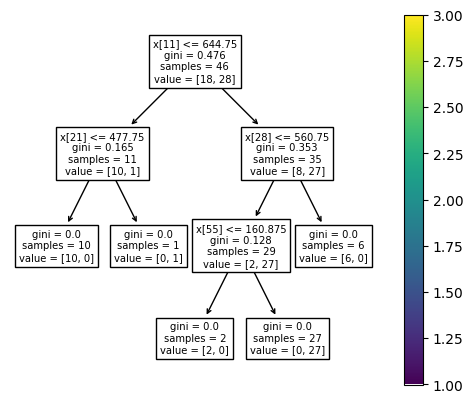

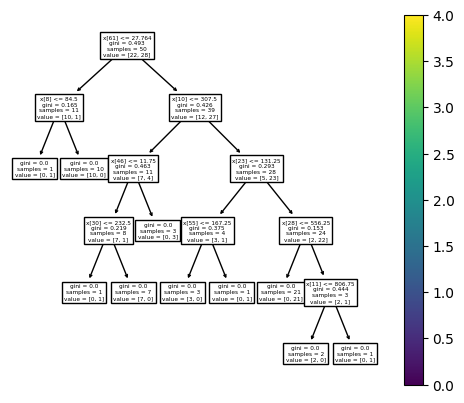

In [27]:
# Apply Decision Tree Model
decisionTreeModel = DecisionTreeModel(X_train_conf_1, X_test_conf_1, y_train_conf_1, y_test_conf_1)
clf = decisionTreeModel.train()
pred = decisionTreeModel.predict(clf)
print(decisionTreeModel.evaluate(pred))
decisionTreeModel.confusion_matrix(pred)
decisionTreeModel.print_tree(clf)

decisionTreeModel = DecisionTreeModel(X_train_conf_2, X_test_conf_2, y_train_conf_2, y_test_conf_2)
clf = decisionTreeModel.train()
pred = decisionTreeModel.predict(clf)
print(decisionTreeModel.evaluate(pred))
decisionTreeModel.confusion_matrix(pred)
decisionTreeModel.print_tree(clf)

{'accuracy': 0.42857142857142855, 'f1_score': 0.5, 'precision': 0.5, 'recall': 0.5}
{'accuracy': 0.6666666666666666, 'f1_score': 0.75, 'precision': 0.75, 'recall': 0.75}


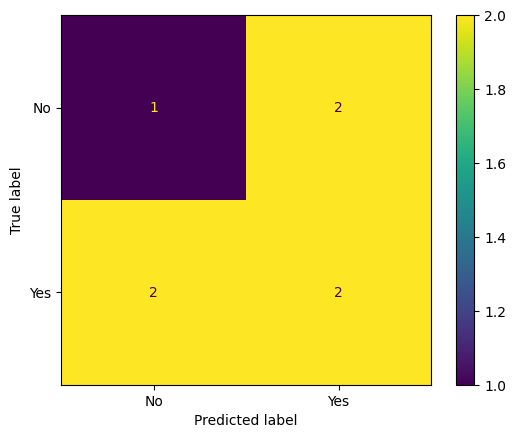

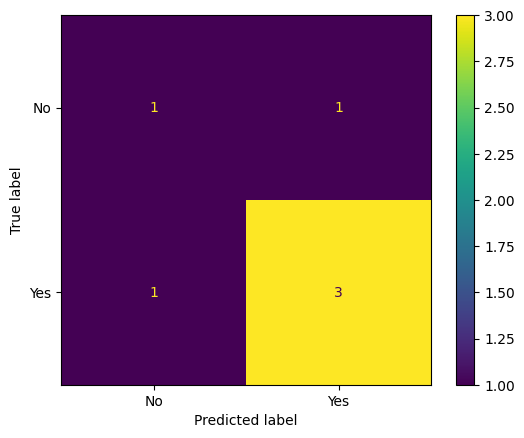

In [30]:
# Apply SVM Model
svmModel = SVMModel(X_train_conf_1, X_test_conf_1, y_train_conf_1, y_test_conf_1)
clf = svmModel.train()
pred = svmModel.predict(clf)
print(svmModel.evaluate(pred))
svmModel.confusion_matrix(pred)

svmModel = SVMModel(X_train_conf_2, X_test_conf_2, y_train_conf_2, y_test_conf_2)
clf = svmModel.train()
pred = svmModel.predict(clf)
print(svmModel.evaluate(pred))
svmModel.confusion_matrix(pred)

{'accuracy': 0.42857142857142855, 'f1_score': 0.5, 'precision': 0.5, 'recall': 0.5}
{'accuracy': 0.6666666666666666, 'f1_score': 0.75, 'precision': 0.75, 'recall': 0.75}


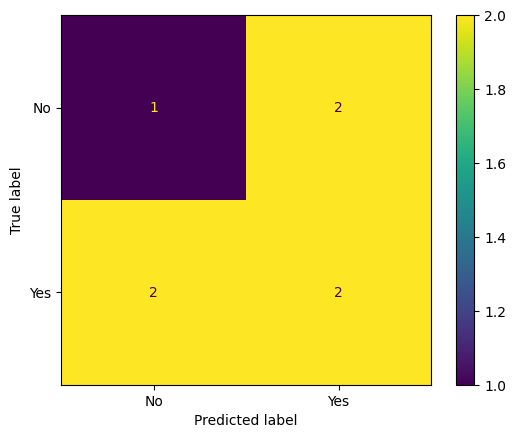

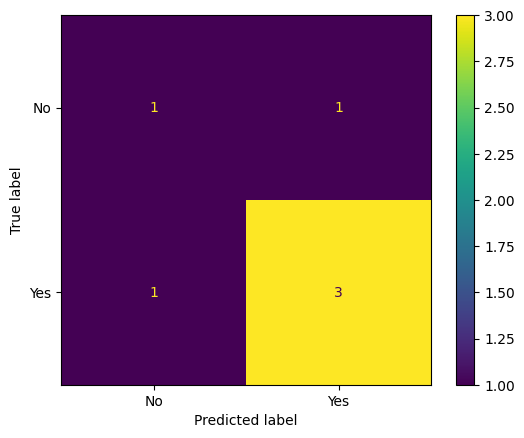

In [32]:
# Apply Naive Bayes Model
naiveBayesModel = NaiveBayesModel(X_train_conf_1, X_test_conf_1, y_train_conf_1, y_test_conf_1)
clf = naiveBayesModel.train()
pred = naiveBayesModel.predict(clf)
print(naiveBayesModel.evaluate(pred))
naiveBayesModel.confusion_matrix(pred)

naiveBayesModel = NaiveBayesModel(X_train_conf_2, X_test_conf_2, y_train_conf_2, y_test_conf_2)
clf = naiveBayesModel.train()
pred = naiveBayesModel.predict(clf)
print(naiveBayesModel.evaluate(pred))
naiveBayesModel.confusion_matrix(pred)

{'accuracy': 0.7142857142857143, 'f1_score': 0.75, 'precision': 0.75, 'recall': 0.75}
{'accuracy': 0.6666666666666666, 'f1_score': 0.75, 'precision': 0.75, 'recall': 0.75}


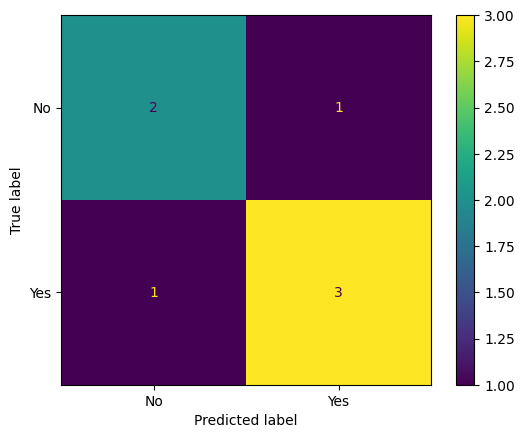

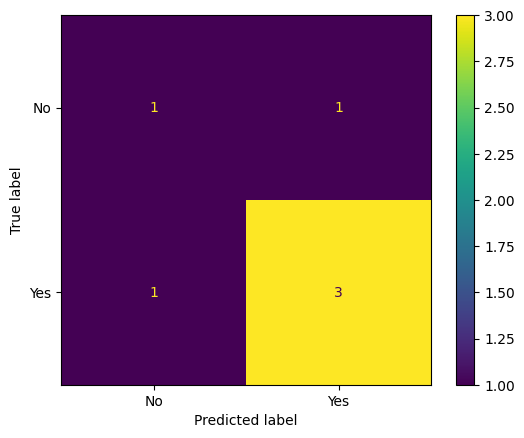

In [38]:
# Apply Neural Network Model
neuralNetworkModel = NeuralNetworkModel(X_train_conf_1, X_test_conf_1, y_train_conf_1, y_test_conf_1)
clf = neuralNetworkModel.train()
pred = neuralNetworkModel.predict(clf)
print(neuralNetworkModel.evaluate(pred))
neuralNetworkModel.confusion_matrix(pred)

neuralNetworkModel = NeuralNetworkModel(X_train_conf_2, X_test_conf_2, y_train_conf_2, y_test_conf_2)
clf = neuralNetworkModel.train()
pred = neuralNetworkModel.predict(clf)
print(neuralNetworkModel.evaluate(pred))
neuralNetworkModel.confusion_matrix(pred)

{'accuracy': 0.14285714285714285, 'f1_score': 0.25, 'precision': 0.25, 'recall': 0.25}
{'accuracy': 0.3333333333333333, 'f1_score': 0.5, 'precision': 0.5, 'recall': 0.5}


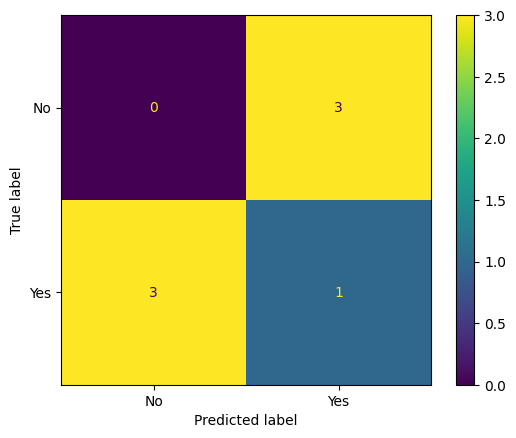

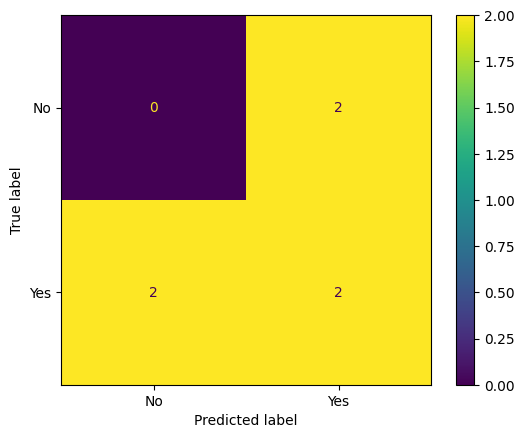

In [18]:
# Apply Logistic Regression Model
logisticRegressionModel = LogisticRegressionModel(X_train_conf_1, X_test_conf_1, y_train_conf_1, y_test_conf_1)
clf = logisticRegressionModel.train()
pred = logisticRegressionModel.predict(clf)
print(logisticRegressionModel.evaluate(pred))
logisticRegressionModel.confusion_matrix(pred)

# Apply Logistic Regression Model
logisticRegressionModel = LogisticRegressionModel(X_train_conf_2, X_test_conf_2, y_train_conf_2, y_test_conf_2)
clf = logisticRegressionModel.train()
pred = logisticRegressionModel.predict(clf)
print(logisticRegressionModel.evaluate(pred))
logisticRegressionModel.confusion_matrix(pred)